# EDA

In [1]:
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

In [2]:
# Loading the data set
df = pd.read_csv("data.csv")
df.columns = [col.strip().lower() for col in df.columns]
print("shape:", df.shape)
df.head()

shape: (10000, 14)


,udi,product id,type,air temperature [k],process temperature [k],rotational speed [rpm],torque [nm],tool wear [min],machine failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0




```
# Dataset Columns Explained

Column Name	Description
UDI	Unique Data Identifier — a unique row index (like a serial number for each observation).
Product ID	Identifier for the specific machine or component (e.g., P001, P002...).
Type	Type of machine or component (e.g., L, M, H — could stand for Low, Medium, High complexity or load).
Air temperature [K]	Temperature of the air surrounding the machine, measured in Kelvin.
Process temperature [K]	Temperature during the machining or processing, in Kelvin.
Rotational speed [rpm]	Rotational speed of the machine spindle (RPM = revolutions per minute).
Torque [Nm]	Torque applied to the machine tool (measured in Newton-meters).
Tool wear [min]	How long the tool has been used (in minutes). Higher wear may indicate aging or damage.
Machine failure	A binary label — 1 means the machine failed, 0 means normal operation. This is your target variable for classification tasks.
TWF	Tool Wear Failure — binary indicator (1 if failure is due to tool wear, else 0).
HDF	Heat Dissipation Failure — binary indicator for failure due to overheating.
PWF	Power Failure — binary indicator for failure due to power issues.
OSF	Overstrain Failure — binary flag for mechanical stress-based failure.
RNF	Random Failure — binary indicator for random, unexplained failures.

```

```


```



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   udi                      10000 non-null  int64  
 1   product id               10000 non-null  object 
 2   type                     10000 non-null  object 
 3   air temperature [k]      10000 non-null  float64
 4   process temperature [k]  10000 non-null  float64
 5   rotational speed [rpm]   10000 non-null  int64  
 6   torque [nm]              10000 non-null  float64
 7   tool wear [min]          10000 non-null  int64  
 8   machine failure          10000 non-null  int64  
 9   twf                      10000 non-null  int64  
 10  hdf                      10000 non-null  int64  
 11  pwf                      10000 non-null  int64  
 12  osf                      10000 non-null  int64  
 13  rnf                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
udi                        0
product id                 0
type                       0
air temperature [k]        0
process temperature [k]    0
rotational speed [rpm]     0
torque [nm]                0
tool wear [min]            0
machine failure            0
twf                        0
hdf                        0
pwf                        0
osf                        0
rnf                        0
dtype: int64


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
udi,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
air temperature [k],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
process temperature [k],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
torque [nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
twf,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
hdf,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
pwf,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


In [6]:
df['type'].value_counts()

type
L    6000
M    2997
H    1003
Name: count, dtype: int64

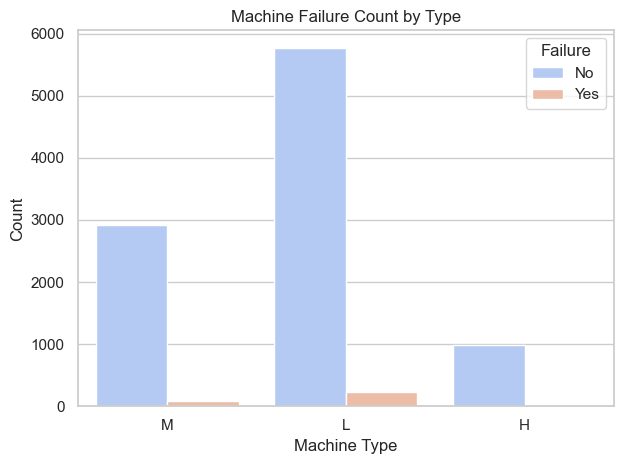

In [7]:
# Count failures and non-failures for each Type
sns.countplot(data=df, x='type', hue='machine failure', palette='coolwarm')

plt.title("Machine Failure Count by Type")
plt.xlabel("Machine Type")
plt.ylabel("Count")
plt.legend(title="Failure", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

In [8]:
# Finding the correlation
corr_matrix = df.select_dtypes(include='number').corr()

In [9]:
corr_matrix

,udi,air temperature [k],process temperature [k],rotational speed [rpm],torque [nm],tool wear [min],machine failure,twf,hdf,pwf,osf,rnf
udi,1.000000,0.117428,0.324428,-0.006615,0.003207,-0.010702,-0.022892,0.009154,-0.022215,-0.023557,-0.000990,-0.005954
air temperature [k],0.117428,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.009955,0.137831,0.003470,0.001988,0.017688
process temperature [k],0.324428,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.007315,0.056933,-0.003355,0.004554,0.022279
rotational speed [rpm],-0.006615,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,0.010389,-0.121241,0.123018,-0.104575,-0.013088
torque [nm],0.003207,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,-0.014662,0.142610,0.083781,0.183465,0.016136
tool wear [min],-0.010702,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.115792,-0.001287,-0.009334,0.155894,0.011326
machine failure,-0.022892,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.362904,0.575800,0.522812,0.531083,0.004516
twf,0.009154,0.009955,0.007315,0.010389,-0.014662,0.115792,0.362904,1.000000,-0.007332,0.008577,0.038243,0.030970
hdf,-0.022215,0.137831,0.056933,-0.121241,0.142610,-0.001287,0.575800,-0.007332,1.000000,0.018443,0.046396,-0.004706
pwf,-0.023557,0.003470,-0.003355,0.123018,0.083781,-0.009334,0.522812,0.008577,0.018443,1.000000,0.115836,-0.004273


In [10]:
# Calculate overall failure rate
failure_rate = df['machine failure'].mean() * 100
print(f"\nOverall machine failure rate: {failure_rate:.2f}%")


Overall machine failure rate: 3.39%


In [11]:
# Count of each failure type
failure_types = ['twf', 'hdf', 'pwf', 'osf', 'rnf']
failure_counts = df[failure_types].sum()
failure_counts

twf     46
hdf    115
pwf     95
osf     98
rnf     19
dtype: int64

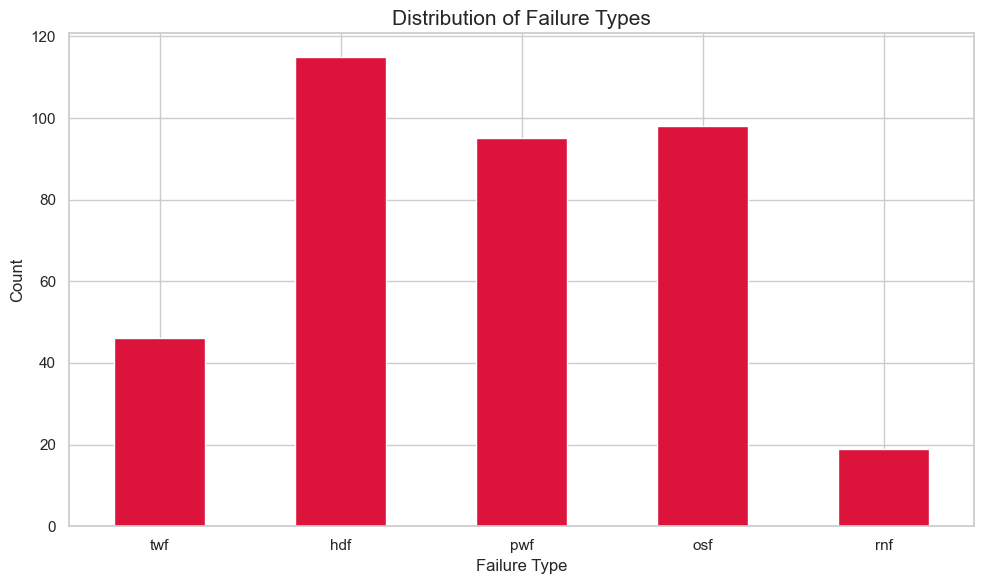

In [12]:
# Visualize failure distribution
plt.figure(figsize=(10, 6))
failure_counts.plot(kind='bar', color='crimson')
plt.title('Distribution of Failure Types', fontsize=15)
plt.xlabel('Failure Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

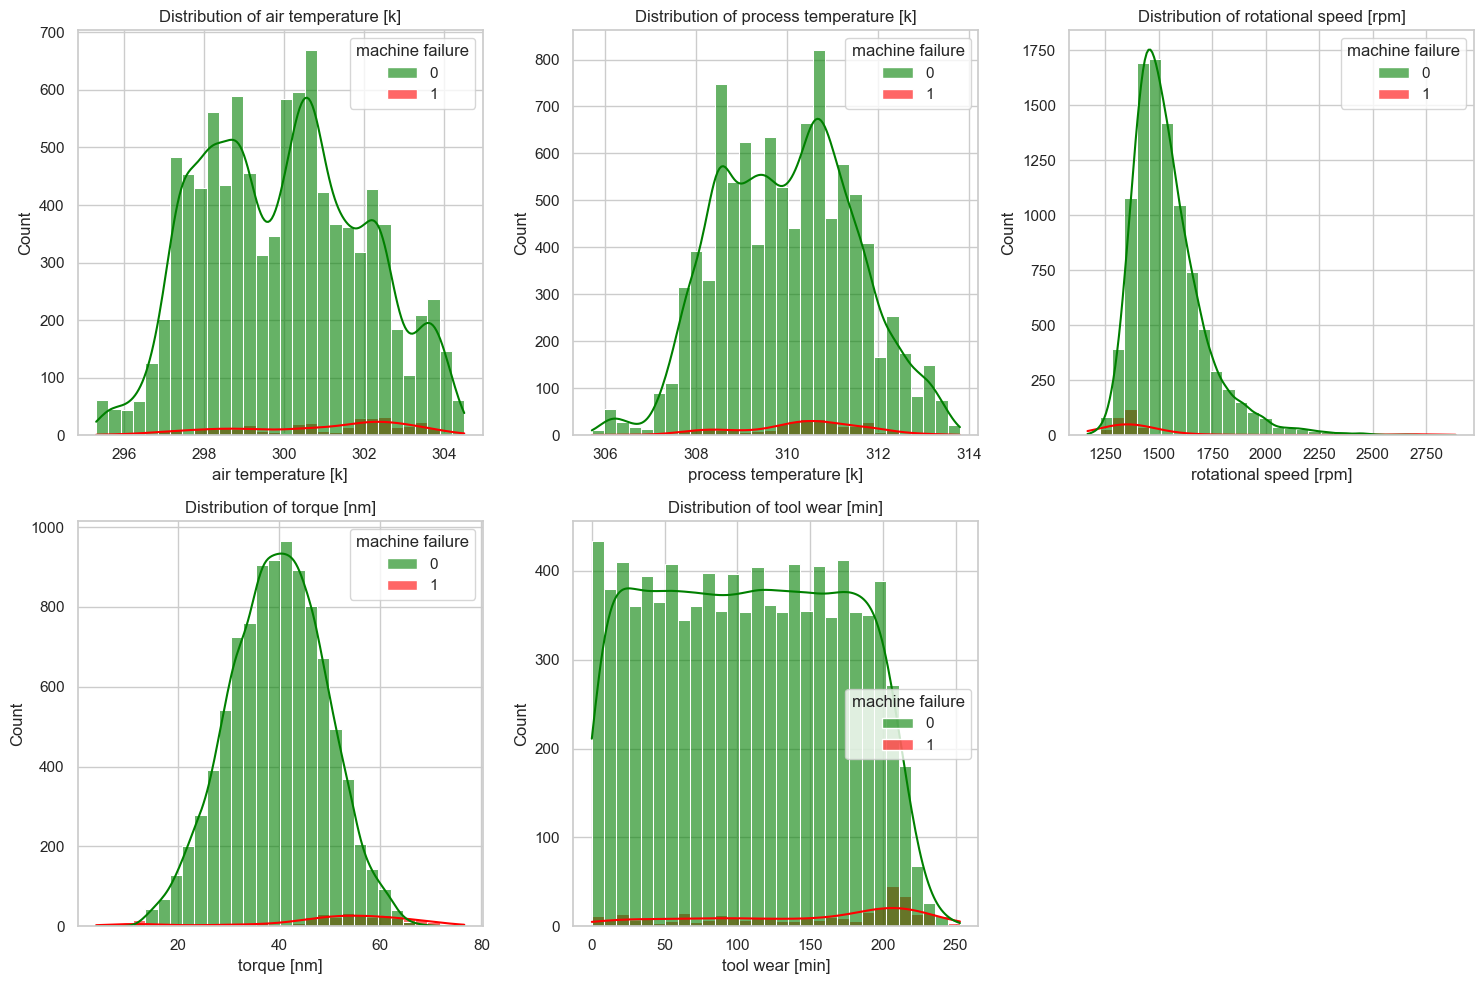

In [13]:
# Define numerical features
numerical_features = ['air temperature [k]', 'process temperature [k]',
                      'rotational speed [rpm]', 'torque [nm]', 'tool wear [min]']

# Create histograms for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    # Plot separate histograms for failed and non-failed cases
    sns.histplot(data=df, x=feature, hue='machine failure', kde=True,
                 palette=['green', 'red'], alpha=0.6, bins=30)
    plt.title(f'Distribution of {feature}', fontsize=12)
plt.tight_layout()
plt.show()

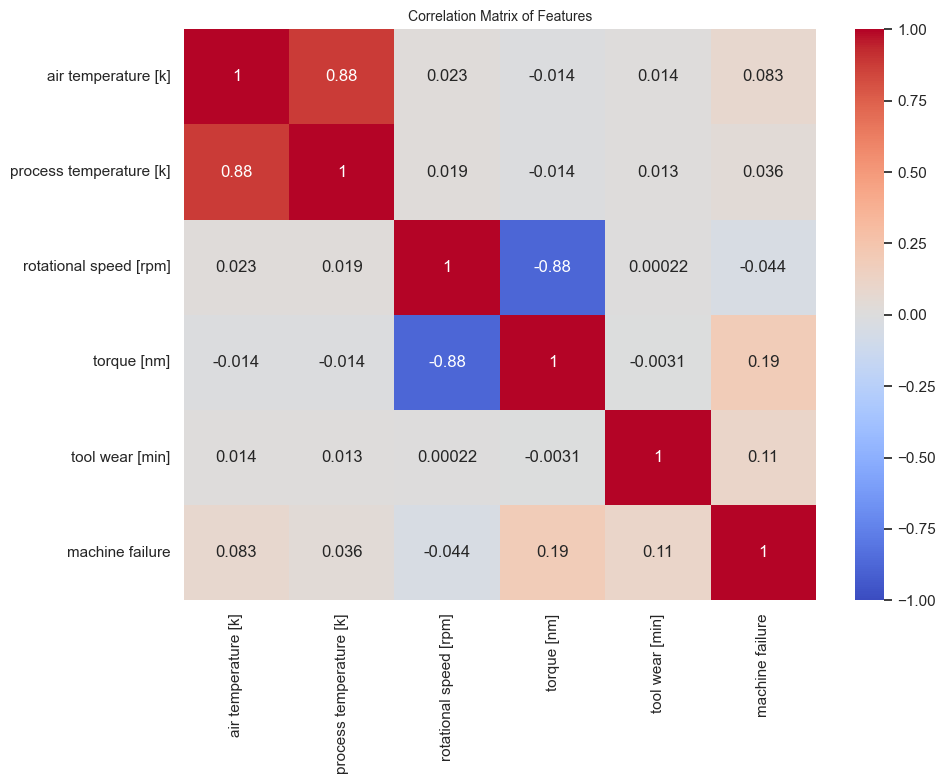

In [14]:
# Calculate correlation matrix
correlation_matrix = df[numerical_features + ['machine failure']].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features', fontsize=10)
plt.tight_layout()
plt.show()

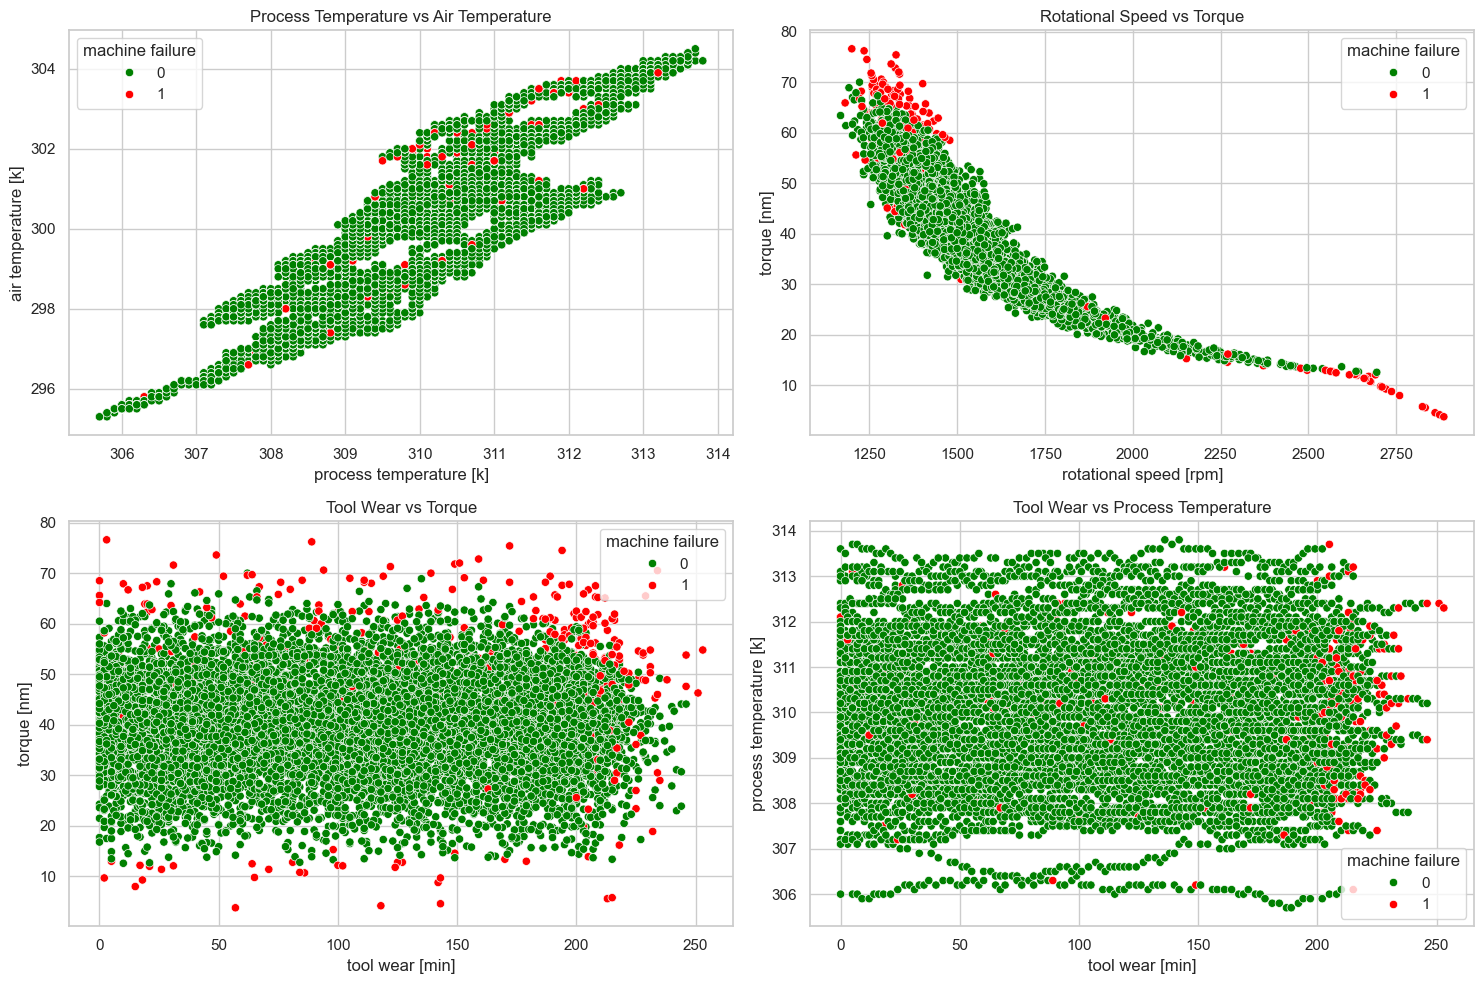

In [15]:
# Create scatter plots to visualize relationships between features
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='process temperature [k]', y='air temperature [k]',
                hue='machine failure', palette=['green', 'red'])
plt.title('Process Temperature vs Air Temperature', fontsize=12)

plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='rotational speed [rpm]', y='torque [nm]',
                hue='machine failure', palette=['green', 'red'])
plt.title('Rotational Speed vs Torque', fontsize=12)

plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='tool wear [min]', y='torque [nm]',
                hue='machine failure', palette=['green', 'red'])
plt.title('Tool Wear vs Torque', fontsize=12)

plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='tool wear [min]', y='process temperature [k]',
                hue='machine failure', palette=['green', 'red'])
plt.title('Tool Wear vs Process Temperature', fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\wer\AppData\Local\Temp\ipykernel_12004\241050145.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='machine failure', y=feature, data=df, palette=['green', 'red'])
C:\Users\wer\AppData\Local\Temp\ipykernel_12004\241050145.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='machine failure', y=feature, data=df, palette=['green', 'red'])
C:\Users\wer\AppData\Local\Temp\ipykernel_12004\241050145.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='machine failure', y=feature, data=df, palette=['green', 'red'])
C:\Users\wer\App

<function matplotlib.pyplot.show(close=None, block=None)>

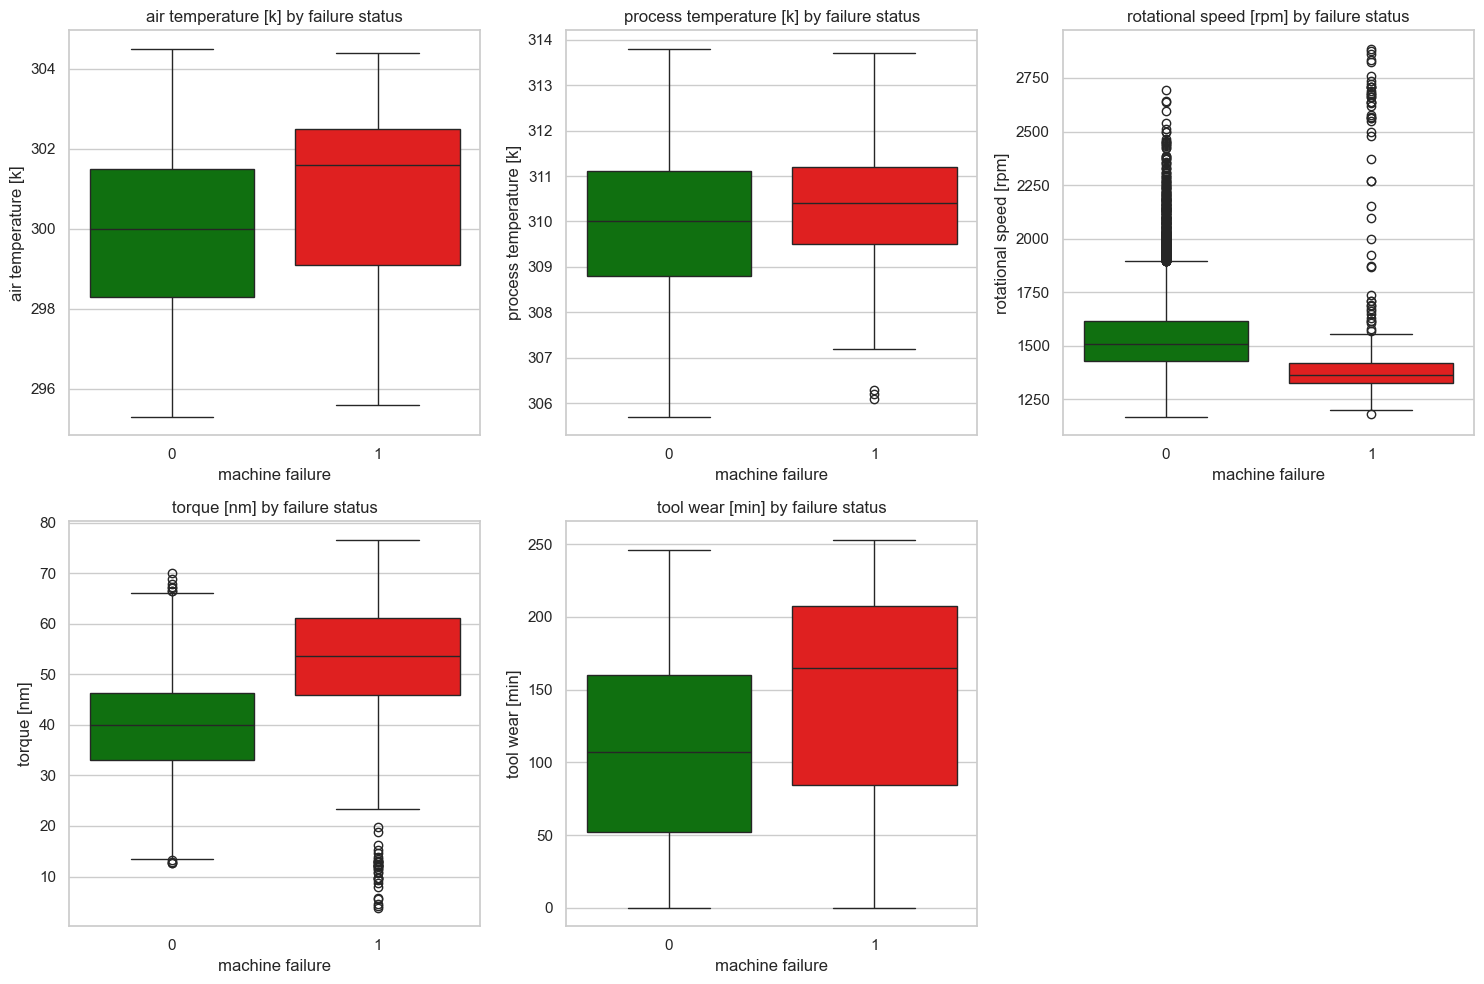

In [16]:
# Create box plots to compare distributions between failed and non-failed states
plt.figure(figsize=(15,10))
for i, feature in enumerate(numerical_features, 1):
  plt.subplot(2,3,i)
  sns.boxplot(x='machine failure', y=feature, data=df, palette=['green', 'red'])
  plt.title(f'{feature} by failure status', fontsize=12)
plt.tight_layout()
plt.show

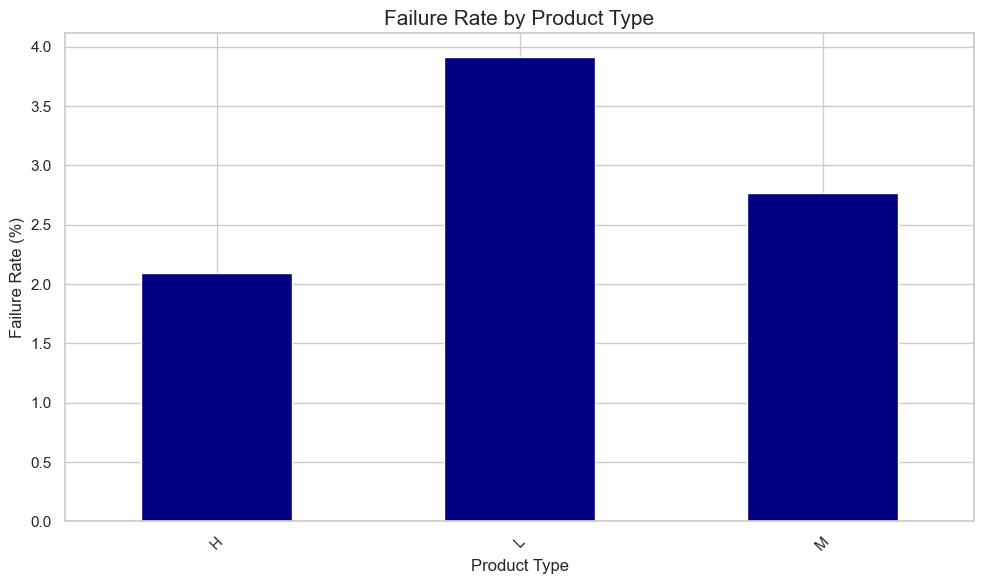

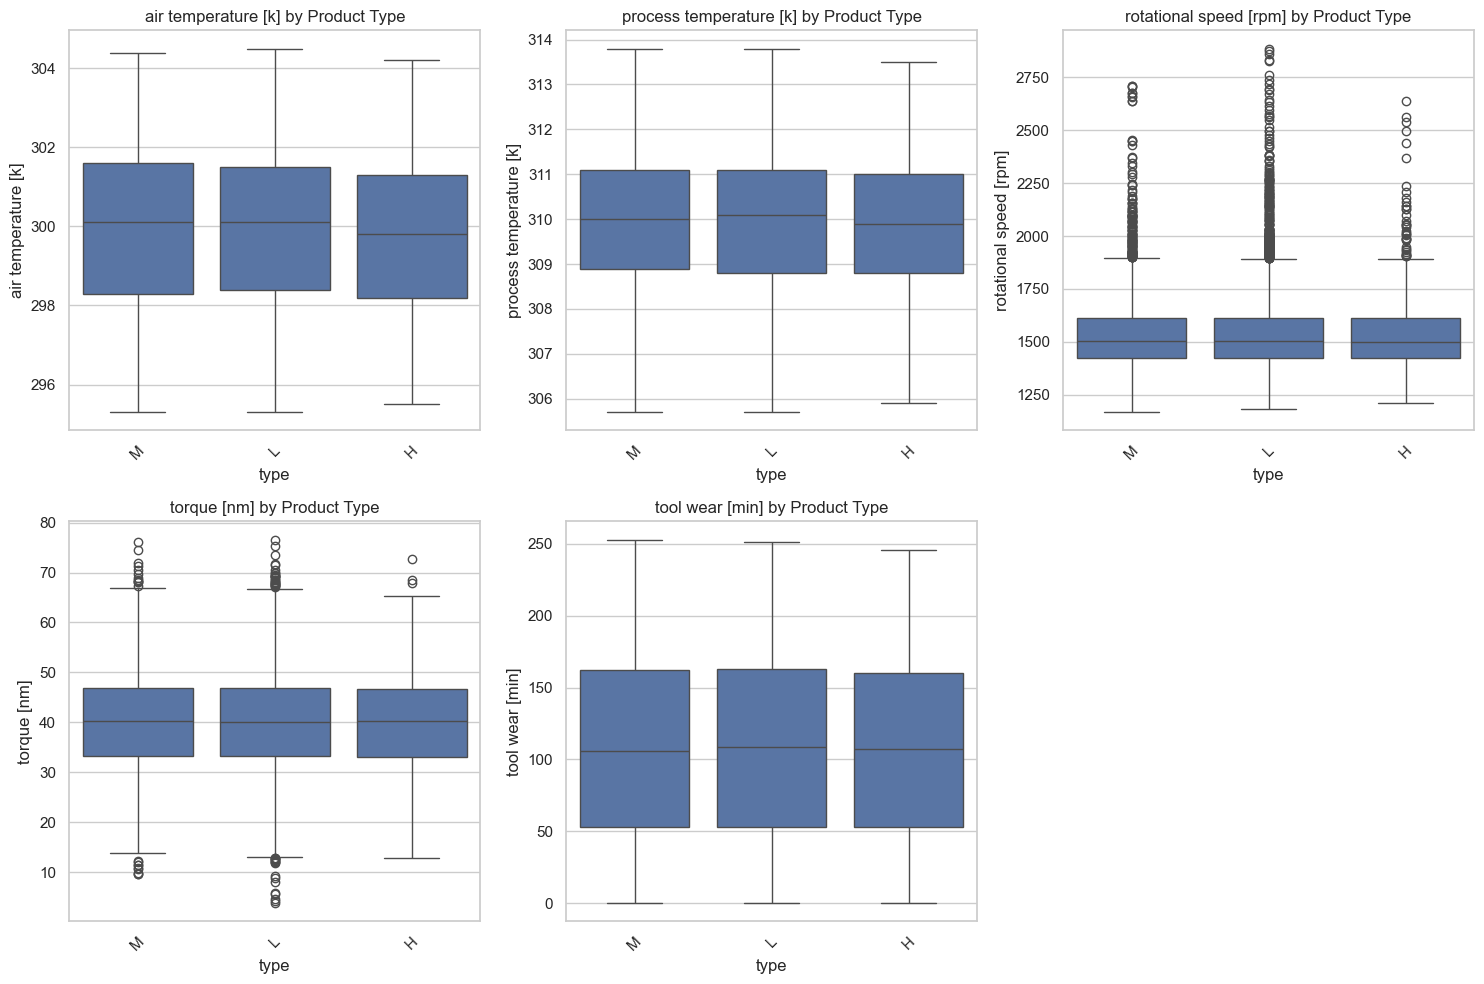

In [17]:
# Calculate failure rates by product type
product_failure = df.groupby('type')['machine failure'].mean() * 100

# Visualize failure rates by product type
plt.figure(figsize=(10, 6))
product_failure.plot(kind='bar', color='navy')
plt.title('Failure Rate by Product Type', fontsize=15)
plt.xlabel('Product Type', fontsize=12)
plt.ylabel('Failure Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compare operating conditions by product type
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='type', y=feature, data=df)
    plt.title(f'{feature} by Product Type', fontsize=12)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\wer\AppData\Local\Temp\ipykernel_12004\2435485940.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tool_wear_failure = df.groupby('tool_wear_bins')['machine failure'].mean() * 100


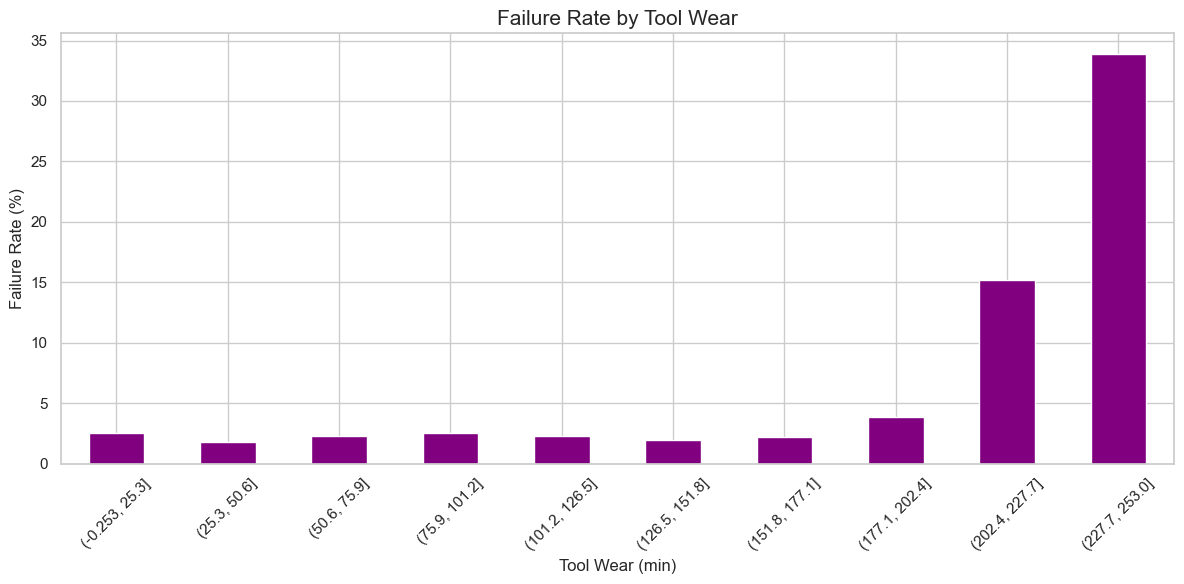

In [18]:
# Create tool wear bins
df['tool_wear_bins'] = pd.cut(df['tool wear [min]'], bins=10)

# Calculate failure rate by tool wear
tool_wear_failure = df.groupby('tool_wear_bins')['machine failure'].mean() * 100

# Visualize failure rate by tool wear
plt.figure(figsize=(12, 6))
tool_wear_failure.plot(kind='bar', color='purple')
plt.title('Failure Rate by Tool Wear', fontsize=15)
plt.xlabel('Tool Wear (min)', fontsize=12)
plt.ylabel('Failure Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Find potential critical thresholds for each feature
threshold_analysis = {}
for feature in numerical_features:
  # Create 10 bins for each feature
  df[f'{feature}_bins'] = pd.cut(df[feature], bins=10)
  # Calculate failure rates for each bin
  failure_by_bin = df.groupby(f'{feature}_bins')['machine failure'].mean() * 100
  # Find the bin where failure rate significantly increases
  avg_failure = failure_by_bin.mean()
  threshold_bins = failure_by_bin[failure_by_bin > avg_failure * 1.5]

  if not threshold_bins.empty:
    threshold_analysis[feature] = threshold_bins.index[0]

print("\nPotential critical thresholds for maintenance triggers:")
for feature, threshold in threshold_analysis.items():
    print(f"{feature}: {threshold}")


Potential critical thresholds for maintenance triggers:
air temperature [k]: (301.74, 302.66]
process temperature [k]: (309.75, 310.56]
rotational speed [rpm]: (2542.4, 2714.2]
torque [nm]: (3.727, 11.08]
tool wear [min]: (202.4, 227.7]


C:\Users\wer\AppData\Local\Temp\ipykernel_12004\1242023166.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_by_bin = df.groupby(f'{feature}_bins')['machine failure'].mean() * 100
C:\Users\wer\AppData\Local\Temp\ipykernel_12004\1242023166.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_by_bin = df.groupby(f'{feature}_bins')['machine failure'].mean() * 100
C:\Users\wer\AppData\Local\Temp\ipykernel_12004\1242023166.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

C:\Users\wer\AppData\Local\Temp\ipykernel_12004\2139399907.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


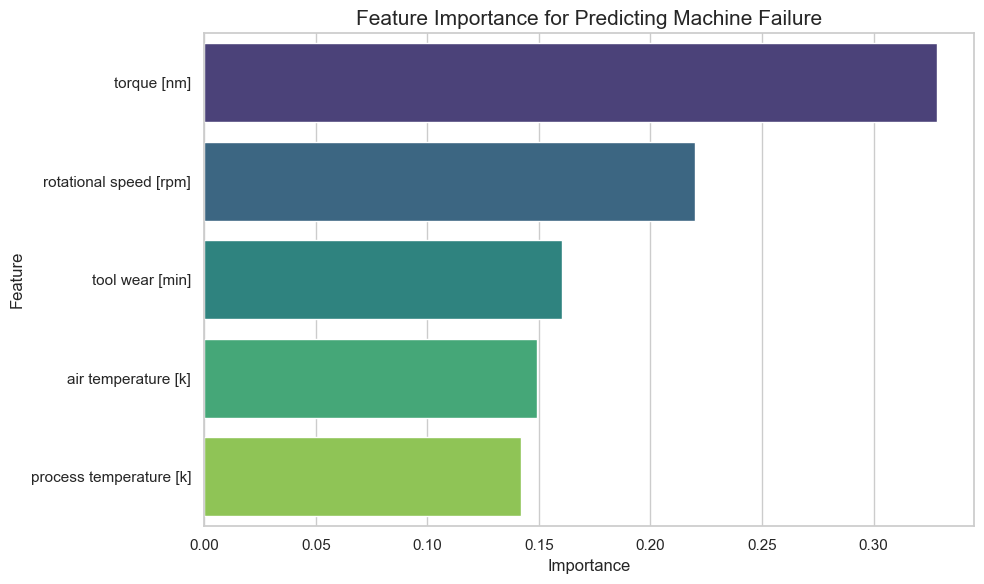

In [20]:
# Feature Importance analysis
from sklearn.ensemble import RandomForestClassifier

# Prepare data for Random Forest
X = df[numerical_features]
y = df['machine failure']

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': numerical_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Predicting Machine Failure', fontsize=15)
plt.tight_layout()
plt.show()

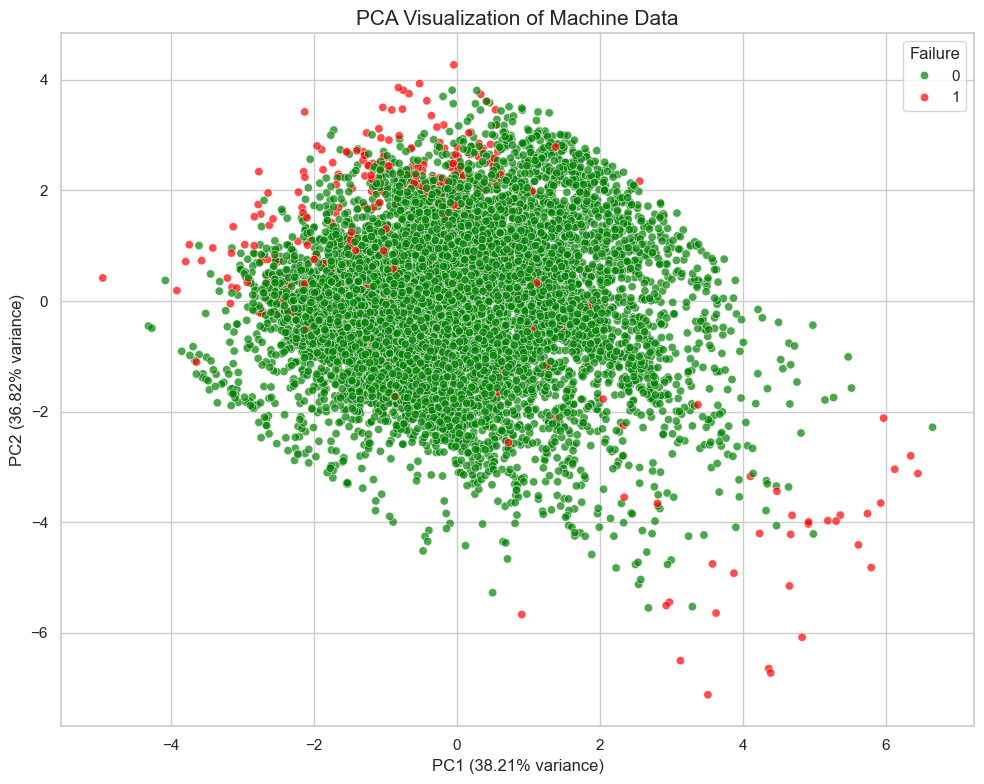

In [21]:
#  Visualizing Failure Patterns with PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardized the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a data frame with PCA results
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Failure': df['machine failure']
})

# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Failure', data=pca_df,
                palette=['green', 'red'], alpha=0.7)
plt.title('PCA Visualization of Machine Data', fontsize=15)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.tight_layout()
plt.show()

In [22]:
# Create a summary of key findings
print("\n" + "="*50)
print("SUMMARY OF KEY FINDINGS")
print("="*50)

print(f"\n1. Overall machine failure rate: {failure_rate:.2f}%")
print(f"2. Most common failure type: {failure_counts.idxmax()} ({failure_counts.max()} occurrences)")

print("\n3. Top 3 most important features for predicting failures:")
for i in range(min(3, len(feature_importance))):
    feature = feature_importance.iloc[i]
    print(f"   - {feature['Feature']} (Importance: {feature['Importance']:.4f})")

print("\n4. Potential critical thresholds for maintenance triggers:")
for feature, threshold in threshold_analysis.items():
    print(f"   - {feature}: {threshold}")

if 'type' in df.columns:
    most_failing_type = product_failure.idxmax()
    print(f"\n5. Product type with highest failure rate: {most_failing_type} ({product_failure.max():.2f}%)")

print("\n6. Correlation insights:")
# Find strongest positive and negative correlations with machine failure
correlations_with_failure = correlation_matrix['machine failure'].drop('machine failure')
strongest_positive = correlations_with_failure.idxmax()
strongest_negative = correlations_with_failure.idxmin()

print(f"   - Strongest positive correlation with failure: {strongest_positive} ({correlation_matrix.loc[strongest_positive, 'machine failure']:.2f})")
print(f"   - Strongest negative correlation with failure: {strongest_negative} ({correlation_matrix.loc[strongest_negative, 'machine failure']:.2f})")


SUMMARY OF KEY FINDINGS

1. Overall machine failure rate: 3.39%
2. Most common failure type: hdf (115 occurrences)

3. Top 3 most important features for predicting failures:
   - torque [nm] (Importance: 0.3286)
   - rotational speed [rpm] (Importance: 0.2198)
   - tool wear [min] (Importance: 0.1604)

4. Potential critical thresholds for maintenance triggers:
   - air temperature [k]: (301.74, 302.66]
   - process temperature [k]: (309.75, 310.56]
   - rotational speed [rpm]: (2542.4, 2714.2]
   - torque [nm]: (3.727, 11.08]
   - tool wear [min]: (202.4, 227.7]

5. Product type with highest failure rate: L (3.92%)

6. Correlation insights:
   - Strongest positive correlation with failure: torque [nm] (0.19)
   - Strongest negative correlation with failure: rotational speed [rpm] (-0.04)


# Feature Engineering

In [23]:
# Set critical threshold from the bin lower bound
critical_threshold = 202.4  # tool wear [min]: (202.4, 227.7]

df['temp_difference'] = df['process temperature [k]'] - df['air temperature [k]']
df['torque_per_rpm'] = df['torque [nm]'] / df['rotational speed [rpm]']
df['is_high_wear'] = (df['tool wear [min]'] > critical_threshold).astype(int)

# Interaction terms between important features
df['temp_wear_interaction'] = df['process temperature [k]'] * df['tool wear [min]']

In [24]:
df.head()

,udi,product id,type,air temperature [k],process temperature [k],rotational speed [rpm],torque [nm],tool wear [min],machine failure,twf,hdf,pwf,osf,rnf,tool_wear_bins,air temperature [k]_bins,process temperature [k]_bins,rotational speed [rpm]_bins,torque [nm]_bins,tool wear [min]_bins,temp_difference,torque_per_rpm,is_high_wear,temp_wear_interaction
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,"(-0.253, 25.3]","(298.06, 298.98]","(308.13, 308.94]","(1511.6, 1683.4]","(40.2, 47.48]","(-0.253, 25.3]",10.5,0.027595,0,0.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,"(-0.253, 25.3]","(298.06, 298.98]","(308.13, 308.94]","(1339.8, 1511.6]","(40.2, 47.48]","(-0.253, 25.3]",10.5,0.032884,0,926.1
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,"(-0.253, 25.3]","(298.06, 298.98]","(308.13, 308.94]","(1339.8, 1511.6]","(47.48, 54.76]","(-0.253, 25.3]",10.4,0.032977,0,1542.5
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,"(-0.253, 25.3]","(298.06, 298.98]","(308.13, 308.94]","(1339.8, 1511.6]","(32.92, 40.2]","(-0.253, 25.3]",10.4,0.027565,0,2160.2
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,"(-0.253, 25.3]","(298.06, 298.98]","(308.13, 308.94]","(1339.8, 1511.6]","(32.92, 40.2]","(-0.253, 25.3]",10.5,0.028409,0,2778.3


# Data Preprocessing for Modeling

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target
X = df[['torque [nm]', 'rotational speed [rpm]', 'tool wear [min]', 'temp_difference',	'torque_per_rpm',	'is_high_wear',	'temp_wear_interaction']]
y = df['machine failure']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building Predictive Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Try several models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    results[name] = {
        'accuracy': model.score(X_test_scaled, y_test),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"\nResults for {name}:")
    print(f"ROC-AUC Score: {results[name]['roc_auc']:.4f}")
    print(f"Confusion Matrix:\n{results[name]['confusion_matrix']}")
    print(f"Classification Report:\n{results[name]['classification_report']}")


Results for Logistic Regression:
ROC-AUC Score: 0.9278
Confusion Matrix:
[[2115  300]
 [  12   73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2415
           1       0.20      0.86      0.32        85

    accuracy                           0.88      2500
   macro avg       0.60      0.87      0.63      2500
weighted avg       0.97      0.88      0.91      2500


Results for Random Forest:
ROC-AUC Score: 0.9714
Confusion Matrix:
[[2408    7]
 [  26   59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2415
           1       0.89      0.69      0.78        85

    accuracy                           0.99      2500
   macro avg       0.94      0.85      0.89      2500
weighted avg       0.99      0.99      0.99      2500


Results for Gradient Boosting:
ROC-AUC Score: 0.9783
Confusion Matrix:
[[2407    8]
 [  19   66]]
Class

# Handling Class Imbalance

In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Create a resampling pipeline
# SMOTE to oversample the minority class (failures)
# Then undersample the majority class for balance
resampling = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('under_sampler', RandomUnderSampler(random_state=42))
])

# Apply resampling
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train_scaled, y_train)

# Train model on resampled data
balanced_model = RandomForestClassifier()
balanced_model.fit(X_train_resampled, y_train_resampled)

# Evaluate
y_pred = balanced_model.predict(X_test_scaled)
print("Balanced model performance:")
print(classification_report(y_test, y_pred))

Balanced model performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2415
           1       0.55      0.84      0.66        85

    accuracy                           0.97      2500
   macro avg       0.77      0.91      0.82      2500
weighted avg       0.98      0.97      0.97      2500



# Hyperparameter Tuning

In [42]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for best model (e.g., Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Get best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC score: {grid_search.best_score_:.4f}")

# Evaluate best model
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC-AUC score: 0.9756
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2415
           1       0.69      0.81      0.75        85

    accuracy                           0.98      2500
   macro avg       0.84      0.90      0.87      2500
weighted avg       0.98      0.98      0.98      2500



# Threshold Optimization

In [30]:
from sklearn.metrics import precision_recall_curve

# Get prediction probabilities
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find threshold with best F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Optimal threshold: {best_threshold:.4f}")
print(f"At this threshold - Precision: {precision[best_threshold_idx]:.4f}, "
      f"Recall: {recall[best_threshold_idx]:.4f}, "
      f"F1: {f1_scores[best_threshold_idx]:.4f}")

# Apply custom threshold to predictions
y_pred_optimized = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_optimized))

Optimal threshold: 0.5813
At this threshold - Precision: 0.8533, Recall: 0.7529, F1: 0.8000
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2415
           1       0.85      0.75      0.80        85

    accuracy                           0.99      2500
   macro avg       0.92      0.87      0.90      2500
weighted avg       0.99      0.99      0.99      2500



# Cost-Benefit Analysis

In [31]:
# Define costs
cost_preventive_maintenance = 100  # Cost of planned maintenance
cost_failure = 1000  # Cost of unplanned downtime and emergency repair
cost_false_alarm = 50  # Cost of unnecessary maintenance

# Calculate confusion matrix with optimized threshold
cm = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm.ravel()

# Calculate total cost
total_cost = (fn * cost_failure) + (fp * cost_false_alarm) + (tp * cost_preventive_maintenance)
savings = (fn + tp) * cost_failure - total_cost  # Compared to no predictive maintenance

print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Total cost with predictive maintenance: ${total_cost}")
print(f"Estimated savings: ${savings}")

Confusion Matrix: TN=2404, FP=11, FN=21, TP=64
Total cost with predictive maintenance: $27950
Estimated savings: $57050


# Deployment Planning

In [32]:
import joblib

# Save the model and preprocessing pipeline
joblib.dump(scaler, 'maintenance_scaler.pkl')
joblib.dump(best_model, 'maintenance_model.pkl')

# Example function for making predictions with new data
def predict_maintenance(new_data):
    # Load model and scaler
    scaler = joblib.load('maintenance_scaler.pkl')
    model = joblib.load('maintenance_model.pkl')

    # Preprocess data
    scaled_data = scaler.transform(new_data)

    # Make prediction
    failure_prob = model.predict_proba(scaled_data)[:, 1]

    # Apply optimized threshold
    needs_maintenance = failure_prob >= best_threshold

    return needs_maintenance, failure_prob

# Monitoring and Feedback Loop

In [33]:
# Pseudocode for model monitoring system
def monitor_model_performance(actual_outcomes, predicted_probabilities):
    # Track prediction quality over time
    current_auc = roc_auc_score(actual_outcomes, predicted_probabilities)

    # Check for concept drift
    if current_auc < historical_auc * 0.9:  # 10% degradation
        print("ALERT: Model performance has degraded significantly")
        print("Consider retraining the model with recent data")

    # Log results for future analysis
    log_performance(timestamp=datetime.now(),
                   metric="ROC-AUC",
                   value=current_auc)

In [34]:
import dagshub

mlflow.set_tracking_uri('https://dagshub.com/Arsalan3043/Predictive-Maintenance-Capstone-proj.mlflow')
dagshub.init(repo_owner='Arsalan3043', repo_name='Predictive-Maintenance-Capstone-proj', mlflow=True)

# mlflow.set_experiment("Logistic Regression Baseline")
mlflow.set_experiment("Predictive_Maintenance_EDA")

Accessing as Arsalan3043

Initialized MLflow to track repo "Arsalan3043/Predictive-Maintenance-Capstone-proj"

Repository Arsalan3043/Predictive-Maintenance-Capstone-proj initialized!

2025/06/01 14:06:12 INFO mlflow.tracking.fluent: Experiment with name 'Predictive_Maintenance_EDA' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/40644470fe3b450dbc83a99dabf21908', creation_time=1748772370578, experiment_id='1', last_update_time=1748772370578, lifecycle_stage='active', name='Predictive_Maintenance_EDA', tags={}>

In [43]:
import mlflow
import logging
import os
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

logging.info("Starting Mlflow run...")

with mlflow.start_run():
    start_time = time.time()

    try:
        logging.info("Logging preprocessing parameters...")
        mlflow.log_param("scaling", "StandardScaler")
        mlflow.log_param("random_state", 42)
        mlflow.log_param("test_size", 0.25)

        # Building Predictive Models
        logging.info("Building Predictive Models...")
        mlflow.log_param("model name", name)
        mlflow.log_params(grid_search.best_params_)

        # Log metrics
        logging.info("logging metrics...")
        mlflow.log_metric("cv_best_roc_auc", grid_search.best_score_)
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("test_roc_auc", roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1]))

        report_dict = classification_report(y_test, y_pred, output_dict=True)
        for label, scores in report_dict.items():
            if isinstance(scores, dict):
                for metric, value in scores.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log model
        logging.info("Logging model to MLflow...")
        mlflow.sklearn.log_model(best_model, artifact_path="model")
        
        # Execution time
        end_time = time.time()
        logging.info(f"Model training and logging completed in {end_time - start_time:.2f} seconds.")

    except Exception as e:
        logging.error(f"An error occurred: {e}", exc_info=True)

2025-06-01 14:49:26,835 - INFO - Starting Mlflow run...
2025-06-01 14:50:36,745 - WARNING - Retrying (Retry(total=6, connect=7, read=6, redirect=7, status=7)) after connection broken by 'ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)': /Arsalan3043/Predictive-Maintenance-Capstone-proj.mlflow/api/2.0/mlflow/runs/create
2025-06-01 14:50:38,260 - INFO - Logging preprocessing parameters...
2025-06-01 14:50:40,737 - INFO - Building Predictive Models...
2025-06-01 14:50:42,378 - INFO - logging metrics...
2025-06-01 14:50:58,759 - INFO - Logging model to MLflow...
2025/06/01 14:51:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-06-01 14:51:41,984 - INFO - Model training and logging completed in 63.72 seconds.


🏃 View run brawny-shark-287 at: https://dagshub.com/Arsalan3043/Predictive-Maintenance-Capstone-proj.mlflow/#/experiments/1/runs/03f55fb826bc4a8aa8ffc193988fdbc0
🧪 View experiment at: https://dagshub.com/Arsalan3043/Predictive-Maintenance-Capstone-proj.mlflow/#/experiments/1
